# open-science-prize-21 
### (gate based solution)  

## Author
Minxi Yang (yang1452@purdue.edu)
### Overview

In IBM open-science-prize-21, the $XXX$ Heisenberg model is asked to be simulated on the IBM Jakarta. 
The goals of this challenge 
is that simulated 3 sites Heisenberg model using at least 4 steps of the 
trotterization on qubit 1, 3, 5 of the IBM Jakarta and obtain the best fidelity for the initial state |110> 
and simulation time $\pi$. <br/>

In my solution, I handle the challenge in three steps.

1. Circuit compression technique: As we know, near-term quantum computing suffers from noise. Most of the noise is sourced from the CNOT gate given the lifetime of qubits and the gate error. Circuit optimization is the most important point that needs to be considered. The goals of the optimization are to reduce the depth of the circuit and the number of the CNOT gates for the simulation. And the noise will be reduced with a short total gate time and less CNOT gate error. In the references [1, 2], a mirror relation of the three alternative layers is discussed. With this relation, any number of the trotterization steps used for the $XY$ Heisenberg model simulation can be compressed into a constant depth of the layers. In my solution, I follow their idea and give a five layers mirror relation as a expended version, since their solution doesn't work on the $XXX$ Heisenberg model. With this five layers mirror relation, I can also compress the circuit for any trotterization steps for the 3-site $XXX$ Heisenberg model simulation, and represent the circuit with a constant number of the layer (total 15 CNOTs) for any evolution time. In the solution, totally 64 steps of the second-order trotterization are compressed and represented by a circuit with total 15 CNOTs and the computation time is about 5 minutes.  

2. Dynamic decoupling: Dynamic decoupling (DD) is a technique which uses the periodic pulse to filp the qubit and neutralized the bath-system interaction [4]. The T1 and T2 lifetime of the qubit is supposed to be extended with the DD. In my solution, I implement the DD with $XYXY$ series by hand on qubit 1, 3 and ancillary qubit 4.  
    
3. Post-processing: Error mitigation using the official qiskit mitigation tool is performed with qubit 1, 3, 5, and ancillary qubit 4 to suppress the readout error. After the error mitigation, the symmetry verification is applied with a measurement in the ancillary qubit [3]. In this technique, the state of one ancillary qubit is used to check if the evolution of the state satisfies the specific symmetry that the target Hamiltonian has. In this solution, qubit 4 is used as the ancillary qubit. In the shots where the result violates the symmetry, qubit 4 is flipped into 1. All the shots which do not pass the verification will are ruled out before the *StateTomographyFitter.fit()*.
<br/>
The solution is generalized to take any input state and evolution time. The information about the input state and the noiseless output state is not needed. In principle, it can work well with unknown input and output states. And only the target circuits and the circuits for the readout error measurement are running, so it is a relatively low-cost solution.
<br/>
Beside the target state and evolution time, I also test performance of solution with the target state and evolution time $\pi/2$, and the input state (|110> + |010>)/$\sqrt{2}$ with the target evolution time. The final results are shown below.

1. Target state and time without DD: state tomography fidelity = $0.8757 \pm 0.0035$
2. Target state and time with DD: state tomography fidelity = $0.8839 \pm 0.0047$
3. Target state and $\pi/2$ time with DD: state tomography fidelity = $0.8208 \pm 0.0100$
4. |110>+|010>/$\sqrt{2}$ state and target time with DD: state tomography fidelity = $0.8648 \pm 0.0094$


1% improvement is observed in the version of the solution with DD. It is really hard to tell if there is a improvement with DD. I still keep DD as part of my final solution since I test DD in the individual qubit and see the significant improvement of the fidelity.  


In [1]:
# import all the packages

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, ClassicalRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import array_to_latex
from qiskit import Aer
import math
import qiskit.quantum_info as qi
from copy import deepcopy
import copy
import numpy as np
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.compiler import transpile
from qiskit import schedule
from scipy.optimize import basinhopping
from IPython.display import Image


Here I provide a list of the version of the packages. The details of all the packages in the envirnoment is listed in "envirnoment.txt".

1. qiskit  0.34.0
2. numpy  1.21.5
3. scipy  1.7.3
4. matplotlib  3.5.1
5. IPython     7.30.1

In [37]:
# set IBM account and backend

IBMQ.save_account('e79582f33d0739f84c7af8d9948f9ebe1f0aab3a97e0d877805890300992dfffc777393f6441e90f7aa73ad011b28732656030e94f3a5dfb762540dfe5feaba1')  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
sim = QasmSimulator()

configrc.store_credentials:WARNING:2022-04-23 04:04:42,803: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-04-23 04:04:43,406: Credentials are already in use. The existing account in the session will be replaced.


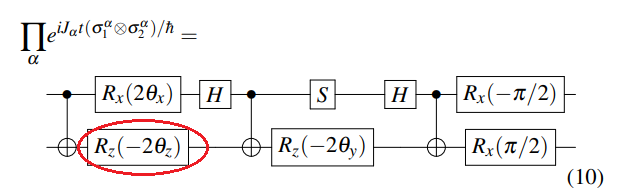

In [3]:
Image(filename='pic/pic1.png')

The optimal circuit of $e^{-i(XX\theta_{x} + YY\theta_{y} + ZZ\theta_{z})}$ from the reference [1] is used. Compared to the solution from the official example, the number of the CNOT gates is reduced from 6 to 3 with the optimal circuit. I notice there is a small error in the reference, the Rz gate labeled by the red circle should be $+2\theta_{z}$.
<br/>

Three such parameterized circuits "XX+YY+ZZ" which represent $e^{-i\beta (XX + YY + ZZ)}$ with the parameters $\beta_{1,2,3}$ are built which will be used late.   

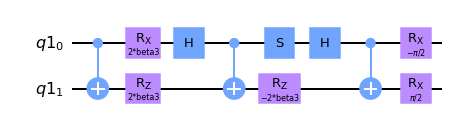

In [5]:
beta1 = Parameter('beta1')
beta2 = Parameter('beta2')
beta3 = Parameter('beta3')

XYZ_qr = QuantumRegister(2)
XYZ_qc = QuantumCircuit(XYZ_qr, name='XX+YY+ZZ')
XYZ_qc.cnot(0,1)
XYZ_qc.rx(2*beta1, 0)
XYZ_qc.rz(2*beta1, 1)
XYZ_qc.h(0)
XYZ_qc.cnot(0,1)
XYZ_qc.s(0)
XYZ_qc.h(0)
XYZ_qc.rz(-2*beta1,1)
XYZ_qc.cnot(0,1)
XYZ_qc.rx(-np.pi/2,0)
XYZ_qc.rx(np.pi/2,1)
XYZ_1 = XYZ_qc.to_instruction()


XYZ_qc = QuantumCircuit(XYZ_qr, name='XX+YY+ZZ')
XYZ_qc.cnot(0,1)
XYZ_qc.rx(2*beta2, 0)
XYZ_qc.rz(2*beta2, 1)
XYZ_qc.h(0)
XYZ_qc.cnot(0,1)
XYZ_qc.s(0)
XYZ_qc.h(0)
XYZ_qc.rz(-2*beta2,1)
XYZ_qc.cnot(0,1)
XYZ_qc.rx(-np.pi/2,0)
XYZ_qc.rx(np.pi/2,1)
XYZ_2 = XYZ_qc.to_instruction()


XYZ_qc = QuantumCircuit(XYZ_qr, name='XX+YY+ZZ')
XYZ_qc.cnot(0,1)
XYZ_qc.rx(2*beta3, 0)
XYZ_qc.rz(2*beta3, 1)
XYZ_qc.h(0)
XYZ_qc.cnot(0,1)
XYZ_qc.s(0)
XYZ_qc.h(0)
XYZ_qc.rz(-2*beta3,1)
XYZ_qc.cnot(0,1)
XYZ_qc.rx(-np.pi/2,0)
XYZ_qc.rx(np.pi/2,1)
XYZ_3 = XYZ_qc.to_instruction()
XYZ_qc.draw('mpl')

I also build an extra circuit "(XX+YY+ZZ)_inv". It is another optimal circuit representation of $e^{-i\beta (XX + YY + ZZ)}$. 
This extra circuit is created by inverting "XX+YY+ZZ" circuit to obtain $e^{i\beta_{1} (XX + YY + ZZ)}$. Then 
change the sign of $\beta_{1}$ to $-\beta_{1}$. 
<br/>
The motivation that I create those circuits will be shown late. 

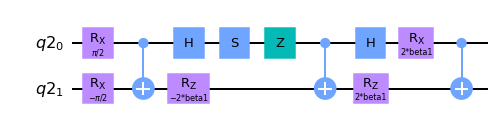

In [6]:
XYZ_qr = QuantumRegister(2)
XYZ_qc = QuantumCircuit(XYZ_qr, name='(XX+YY+ZZ)_inv')
XYZ_qc.rx(-np.pi/2,1)
XYZ_qc.rx(np.pi/2,0)
XYZ_qc.cnot(0,1)
XYZ_qc.rz(-2*beta1,1)
XYZ_qc.h(0)
XYZ_qc.s(0)
XYZ_qc.z(0)
XYZ_qc.cnot(0,1)
XYZ_qc.h(0)
XYZ_qc.rz(2*beta1, 1)
XYZ_qc.rx(2*beta1, 0)
XYZ_qc.cnot(0,1)
XYZ_1_inv = XYZ_qc.to_instruction()
XYZ_qc.draw('mpl')

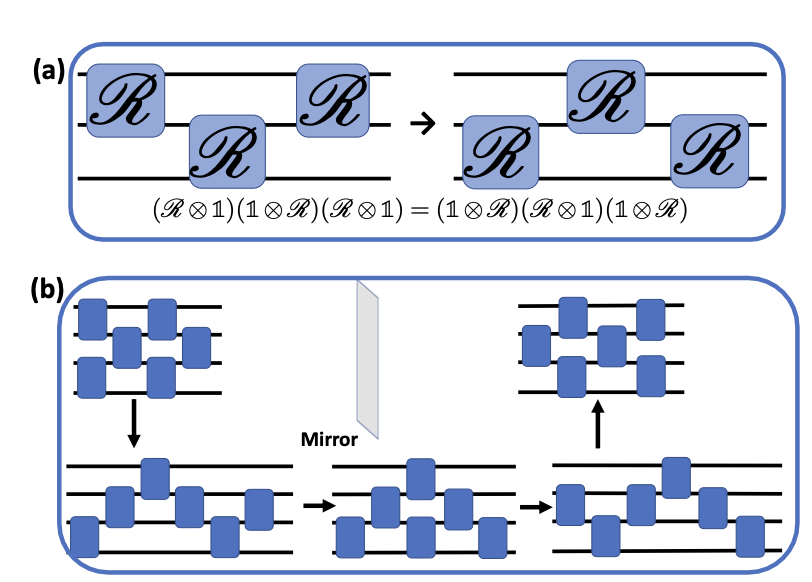

In [7]:
Image(filename='pic/pic2.png')

Yang-Baxter-like mirror relation of the quantum circuit came up with the references[1]. The main idea for this relation is that try to find a mirrored circuit for the three alternative layers circuit which represents the same unitary operator. By applying this mirror relation many times and merging the adjacent layers, any number of the trotter step can be represented by a constant depth.
<br/>
However, in the reference [1] only the example and analytical form of this mirror relation for $XY$ Heisenberg model are provided. And in another reference [2], a conjecture with the name **Conjecture 3** is discussed which is the same as the Yang-Baxter-like mirror relation. However, the main example they discussed is still the $XY$ Heisenberg model. Unfortunately, I found that the 3 alternative layers mirror relation does not exist in $XXX$ Heisenberg model (which means there is no solution in general). 

  
Although **Conjecture 3** doesn't work in our case, it will not stop me to find a conjecture relation with more layers. In this solution, I come up with a **Conjecture 5** relation with the analytical form. Instead of finding a mirrored circuit for the three alternative layers circuit, I try to find this relation with the five alternative layers circuit. I cannot prove that this relation always exists in $XXX$ Heisenberg model. However, all the numerical tests with the different parameters for **Conjecture 5** succeed.

# Conjecture 5

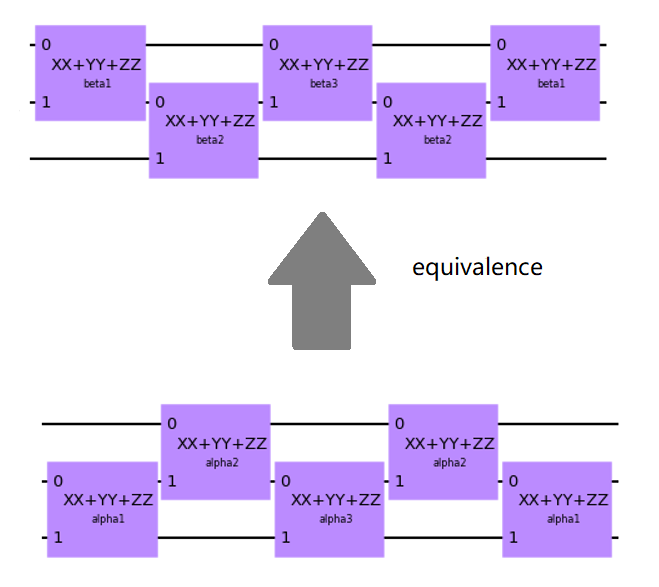

In [7]:
Image(filename='pic/pic3.png')

**Conjecture 5**: <br/>
For any five alternative layers circuit shown above and with the parameterss $\alpha_{1,2,3}$, a corresponding circuit with the parameters $\beta_{1,2,3}$ which represents same unitary operator exist. 
<br/>
<br/>
I add an additional mirror symmetry constraint on the circuit based on invertibility of the circuit. So, only three parameters are used to describe the circuit. 

The analytical form of **Conjecture 5** is shown below:
$$
  f_{1}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{1}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{2}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{2}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{3}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{4}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{4}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{3}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{5}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{5}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$

Where $f_{i}$ are:

$$
f_{1}(x, y, z) = cos(2x)cos(2y)cos(z) - sin(2x)cos(y)^{2}sin(z)
$$

$$
f_{2}(x, y, z) = -sin(x)^{2}sin(2y)cos(z) - cos(x)^{2}sin(y)^{2}sin(z) - 0.5sin(2x)sin(2y)sin(z)
$$

$$
f_{3}(x, y ,z) = cos(2x)cos(y)^{2}sin(z) + sin(2x)cos(2y)cos(z)
$$

$$
f_{4} = cos(x)^{2}sin(2y)cos(z) + sin(x)^{2}sin(y)^{2}sin(z) - 0.5sin(2x)sin(2y)sin(z)
$$

$$
f_{5} = -0.5sin(2x)sin(2y)cos(z) -0.5cos(2x)sin(2y)sin(z) + 0.5sin(2x)sin(y)^{2}sin(z)
$$

The deduction of the analytical form are shown in the appendix. C.

I create a *mirror_cost* function to return a cost $C$:
$$
C = (f_{1}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{1}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2} + 
(f_{2}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{2}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2} +
(f_{3}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{4}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2} +
(f_{4}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{3}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2} +
(f_{5}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) - f_{5}(2\beta_{1}, 2\beta_{2}, 2\beta_{3}))^{2}
$$

<br/>

For any fixed $\beta_{1,2,3}$, I numerically optimize the $C$ to 0 and obtain the corresponding $\alpha_{1,2,3}$. Then the mirrored circuit is found. I cannot prove there is always a solution with $C = 0$ (so, it is a conjecture). However, multiple numerical tests are performed which are shown in the appendix. B. 

In [8]:
def f1(x, y, z): # I
    
    f = np.cos(2*x)*np.cos(2*y)*np.cos(z) - np.sin(2*x)*np.cos(y)**2*np.sin(z)
    return f

def f2(x, y, z): # pt-1
    

    f = -np.sin(x)**2*np.sin(2*y)*np.cos(z) - np.cos(x)**2*np.sin(y)**2*np.sin(z) - 0.5*np.sin(2*x)*np.sin(2*y)*np.sin(z)
    return f

def f3(x, y, z): # p
    
    f = np.cos(2*x)*np.cos(y)**2*np.sin(z) + np.sin(2*x)*np.cos(2*y)*np.cos(z)
    return f

def f4(x, y, z): # pt 
    
    f = np.cos(x)**2*np.sin(2*y)*np.cos(z) + np.sin(x)**2*np.sin(y)**2*np.sin(z) - 0.5*np.sin(2*x)*np.sin(2*y)*np.sin(z)
    return f

def f5(x, y, z): # t + t-1
    
    
    f = -0.5*np.sin(2*x)*np.sin(2*y)*np.cos(z) - 0.5*np.cos(2*x)*np.sin(2*y)*np.sin(z) + 0.5*np.sin(2*x)*np.sin(y)**2*np.sin(z)
    return f


def mirror_cost(alphas, *betas): #cost function
    
    alpha1, alpha2, alpha3 = alphas
    beta1, beta2, beta3 = betas

    eq1 = f1(alpha1, alpha2, alpha3) - f1(beta1, beta2, beta3)
    eq2 = f2(alpha1, alpha2, alpha3) - f2(beta1, beta2, beta3)
    eq3 = f3(alpha1, alpha2, alpha3) - f4(beta1, beta2, beta3)
    eq4 = f4(alpha1, alpha2, alpha3) - f3(beta1, beta2, beta3)
    eq5 = f5(alpha1, alpha2, alpha3) - f5(beta1, beta2, beta3)
    
    return eq1**2 + eq2**2 + eq3**2 + eq4**2 + eq5**2

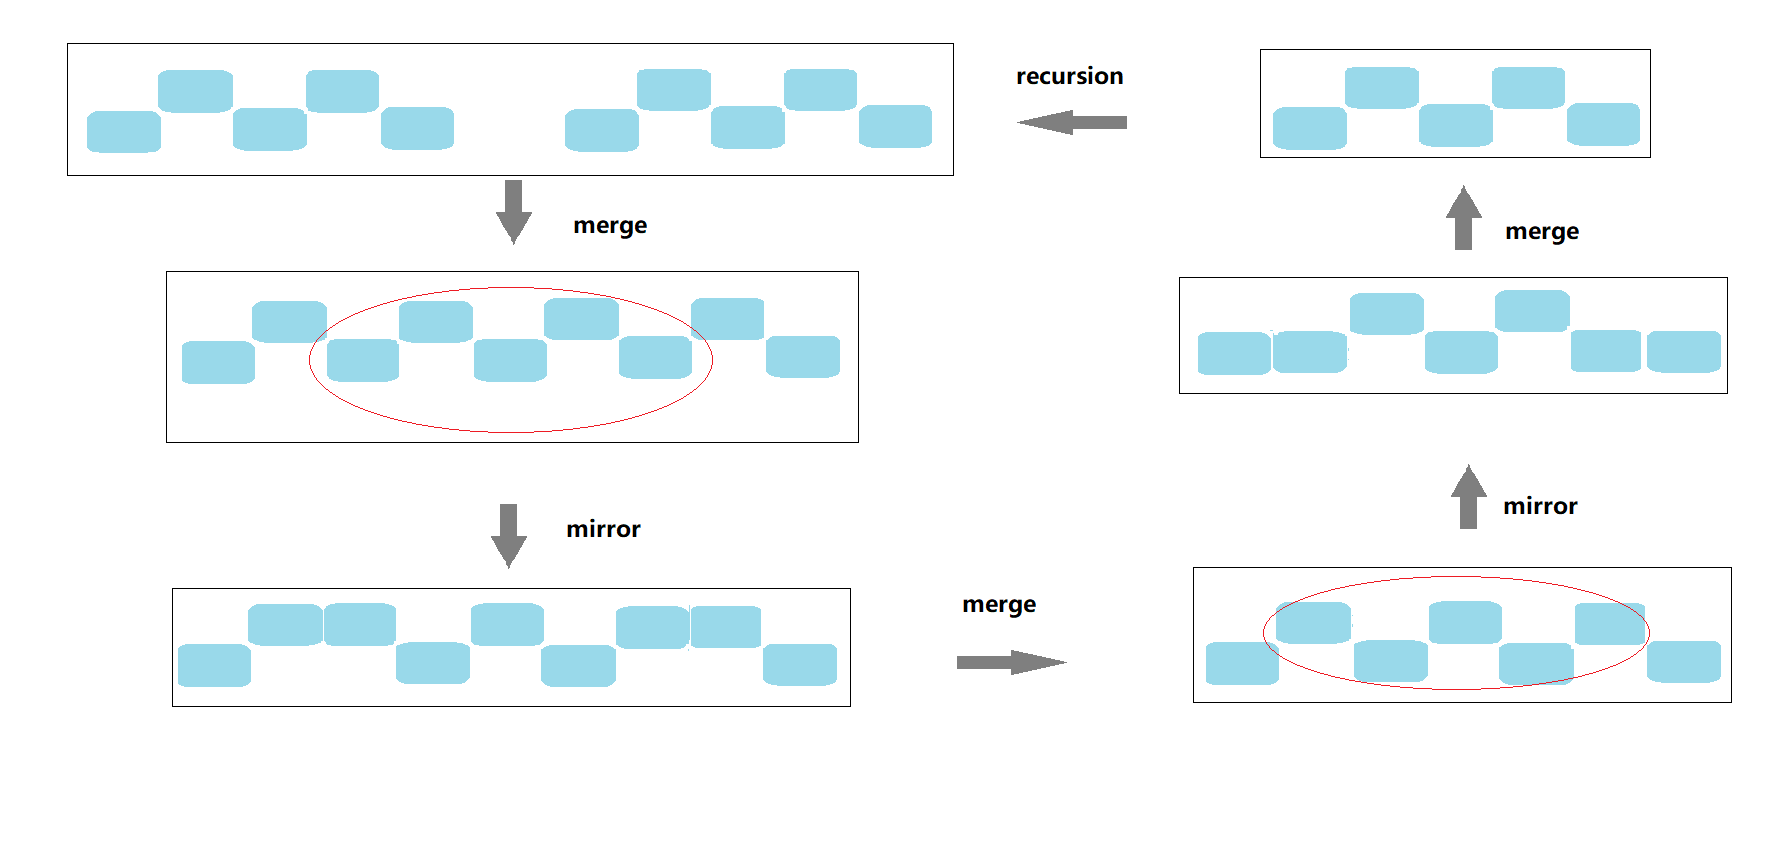

In [9]:
Image(filename='pic/pic5.png')

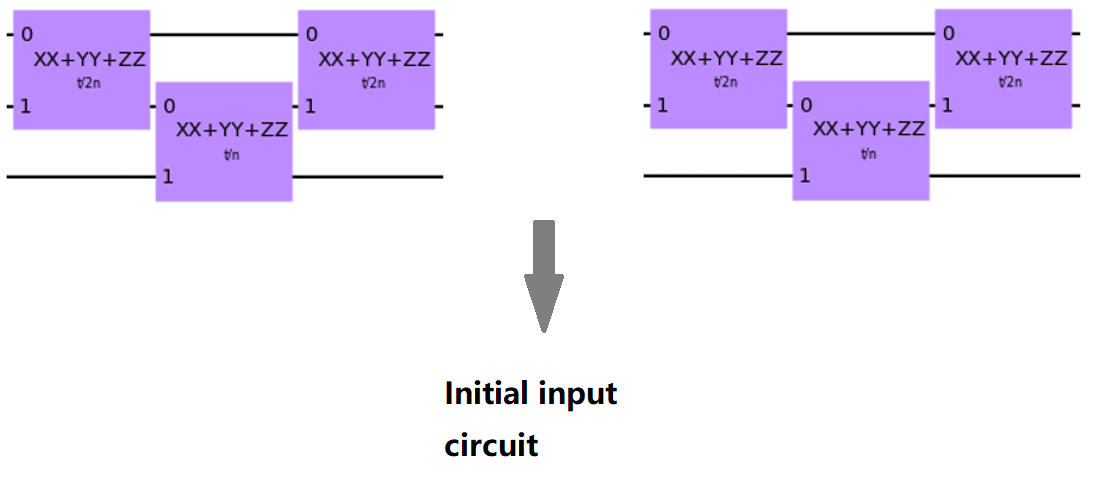

In [10]:
Image(filename='pic/pic6.png')

The calculation of the parameters for the compressed circuit is performed with a function *compression*, which takes the number of the iteration $n$ and total evolution time $t$ as the input. In each iteration, two five alternative layers blocks are compressed into one which is shown above. The output compressed layers from the last iteration enter into the next iteration as the input and algorithm work recursively.
<br/>
In the first iteration, two second-order trotterization are merged into a five alternative layers block as the initial input.
<br/>
With $n$ times iteration, $2^{n+1}$ second-order trotterization steps are compressed and represented by five alternative layers block. 
<br/>
In *compression* function, *scipy.optimize.basinhopping* is used find the global minimal of the cost function $C$. The search might repeat many times until the cost function $C < 10^{-16}$ with the searched result.
<br/>
The output of the *compression* are the three parameters for the final compressed circuit which represents $2^{n+1}$ second-order trotterization steps. 
<br/>
 Compared to **Conjecture 3**, **Conjecture 5** cannot be easily applied in the N-site Heisenberg model. However, it is good enough to solve our 3 sites $XXX$ Heisenberg model simulation. And it might be useful to provide an angle to find a shallow circuit representation for the quantum simulation with the Hamiltonian with certain symmetries. 

In [56]:
def compression(n, t): # iteration number n and the evolution time t
    
    init_v = -2*t/2**(n+1)
    betas0 = [0.5*init_v, init_v, init_v] #initial input parameters for the second-order trotterization#
    bounds = [(-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi)]
    
    for i in range(n): #iteration 

        betas=[0,0,0]
        betas[0] = betas0[2]
        betas[1] = betas0[1]
        betas[2] = 2*betas0[0]
        betas[2] = (betas[2]+np.pi) % (2*np.pi) - np.pi
        betas = tuple(betas)
        for j in range(2):
            minimizer_kwargs = {"args":betas, "bounds": bounds,"method":"L-BFGS-B", "jac":"3-point"}
            cost = 1
            while cost > 1e-16: # Only when cost less than 10^(-16), the optimization is succeed.  

                result = basinhopping(
                              mirror_cost, 
                              deepcopy(betas), 
                              minimizer_kwargs=minimizer_kwargs, 
                              niter=1000,
                              stepsize = 0.2,
                              T = 3.
                                 )
                cost = result.fun
    
            alphas = deepcopy(result.x)
            alphas[0]+=betas0[1-j] # merge the parameters of the adjacent layers
            alphas[0] = (alphas[0]+np.pi) % (2*np.pi) - np.pi # keep the parameters within the range
            betas = tuple(deepcopy(alphas))
        betas0 = list(betas)
    paras = [-betas0[0]/2., -betas0[1]/2., -betas0[2]/2.]
    return paras # return the paramters for the final compressed circuit

In the cell below, the parameters of the compressed circuit with the target evolution time $\pi$ are calculated. I also tested evolution time $\pi/2$ and calculate the circuit parameters for it. In principle, any number of the steps of the trotterization can be represented by this 5 layers circuit. In my study, the circuit compression is performed with five iterations and a total of 64 steps of the second-order since the result is good enough. 

It takes 5 to 10 minutes to run the next cell and calculate the compressed circuit parameters for evolution time $\pi$ and $\pi/2$. 

In [12]:
target_time = np.pi
paras_pi = compression(5, target_time) # compressed circuit parameters for evolution time pi
paras_half_pi = compression(5, target_time/2.) # compressed circuit parameters for evolution time pi/2

In the next cell, the compressed trotterization circuit for evolution time $\pi$ is created. 

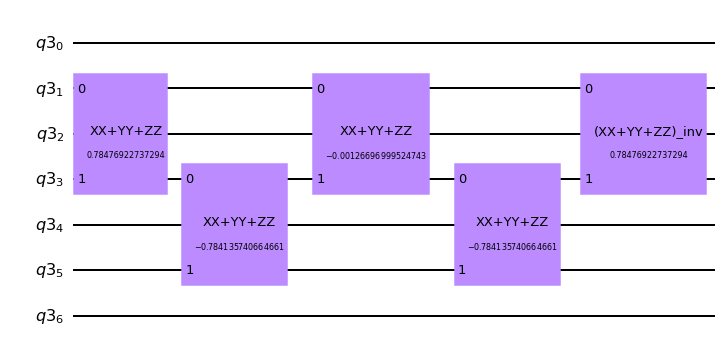

In [13]:
num_qubits = 7
qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(qr, name='Trot_pi')
Trot_qc.append(XYZ_1, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_3, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_1_inv, [qr[1], qr[3]])
Trot_qc=Trot_qc.bind_parameters({beta1:paras_pi[0],beta2:paras_pi[1], beta3:paras_pi[2]})
Trot_pi = Trot_qc.to_instruction()
Trot_qc.draw('mpl')


In the next cell, the entire trotterization circuit is optimized to the empty which *optimization_level=3* during the transpile, which means do nothing with the input quantum state.
<br/>
I provide the eigenstates and eigenvalues of the target Hamiltonian in the appendix. A. The eigenvalues of the target Hamiltonian are $[-4, 0 ,2]$, and the target evolution time $\pi$ is a special case with this set of the eigenvalues. The noiseless evolved state is identical to the input state since: 
$$
U = e^{-itH} = e^{-i(-4/2/0)\pi} = 1
$$

So, an empty circuit and doing nothing is the optimal solution with this special evolution time. In principle, I this solution with this empty circuit is valid because my method with the IBM circuit optimization algorithm adaptively reduce 64 steps of the trotterization to an empty circuit for this specific evolution time without any knowledge of the eigenstates and eigenvalues. It will give an extremely high fidelity, which is more than 0.99 after the error mitigation to reduce the readout error.
<br/>
However, I am still not sure if this solution is within the scope of the challenge. I will keep the five alternative layers circuit as the basic structure in **Conjecture 5**, and do not optimize it regarding the evolution time. I will also test my solution with the evolution time $\pi/2$ which is not so special. 

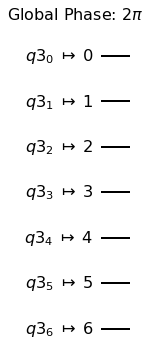

In [14]:
Trot_test = transpile(Trot_qc, optimization_level=3,backend=sim_noisy_jakarta)

Trot_test.draw('mpl')

In the following cell, *approximation_degree=1.* help me to keep the basic structure of the circuit. 

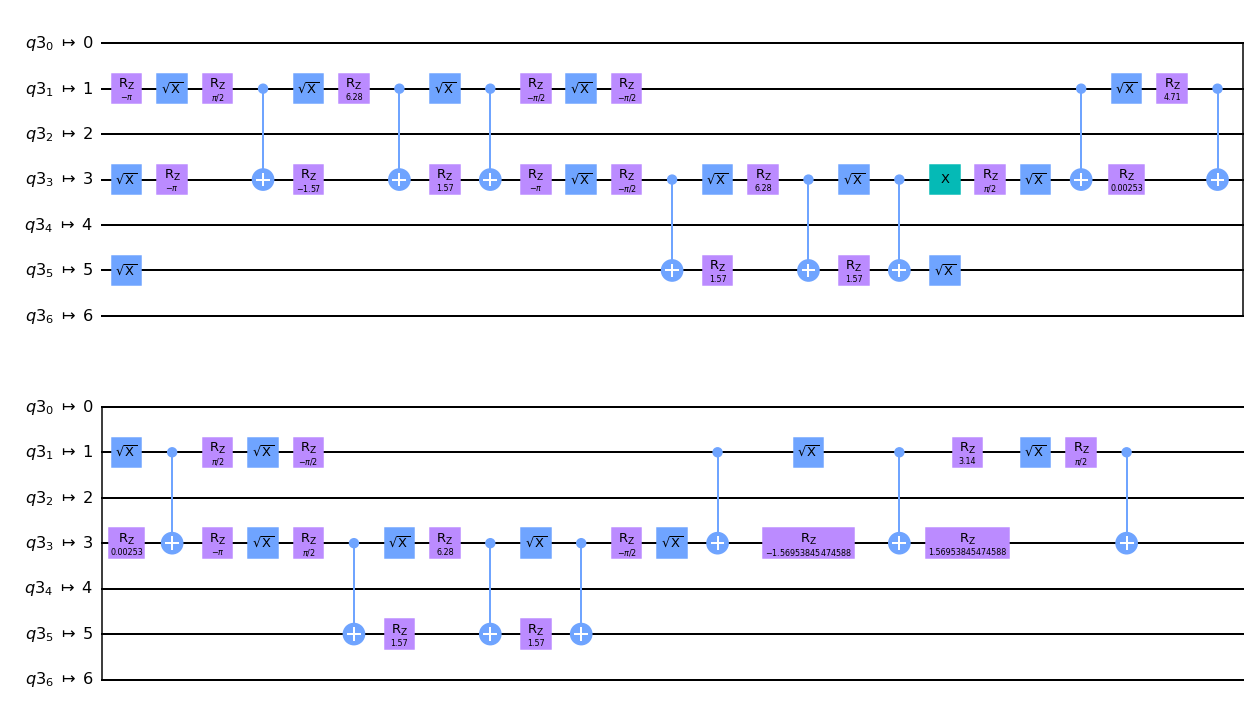

In [15]:
Trot_test = transpile(Trot_qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)

Trot_test.draw('mpl')

In the following cell, a compressed trotterization circuit for evolution time $\pi/2$ is created.

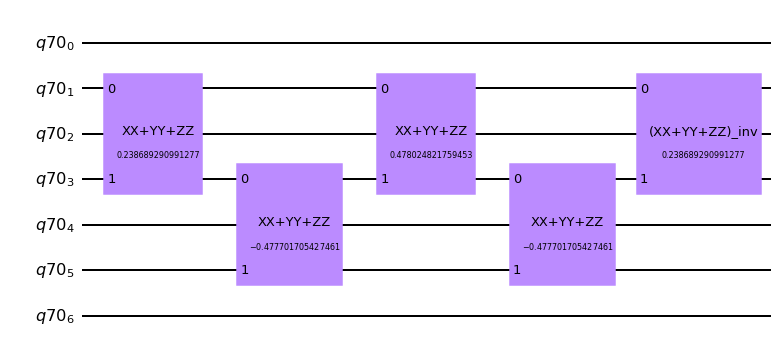

In [16]:
num_qubits = 7
qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(qr, name='Trot_half_pi')
Trot_qc.append(XYZ_1, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_3, [qr[1], qr[3]])
Trot_qc.append(XYZ_2, [qr[3], qr[5]])
Trot_qc.append(XYZ_1_inv, [qr[1], qr[3]])
Trot_qc=Trot_qc.bind_parameters({beta1:paras_half_pi[0],beta2:paras_half_pi[1], beta3:paras_half_pi[2]})
Trot_half_pi = Trot_qc.to_instruction()
Trot_qc.draw('mpl')

The simulation with the evolution time $\pi$ is a special case. With the evolution time $\pi/2$, the transpile does not change the circuit structure even without *approximation_degree=1.*. 

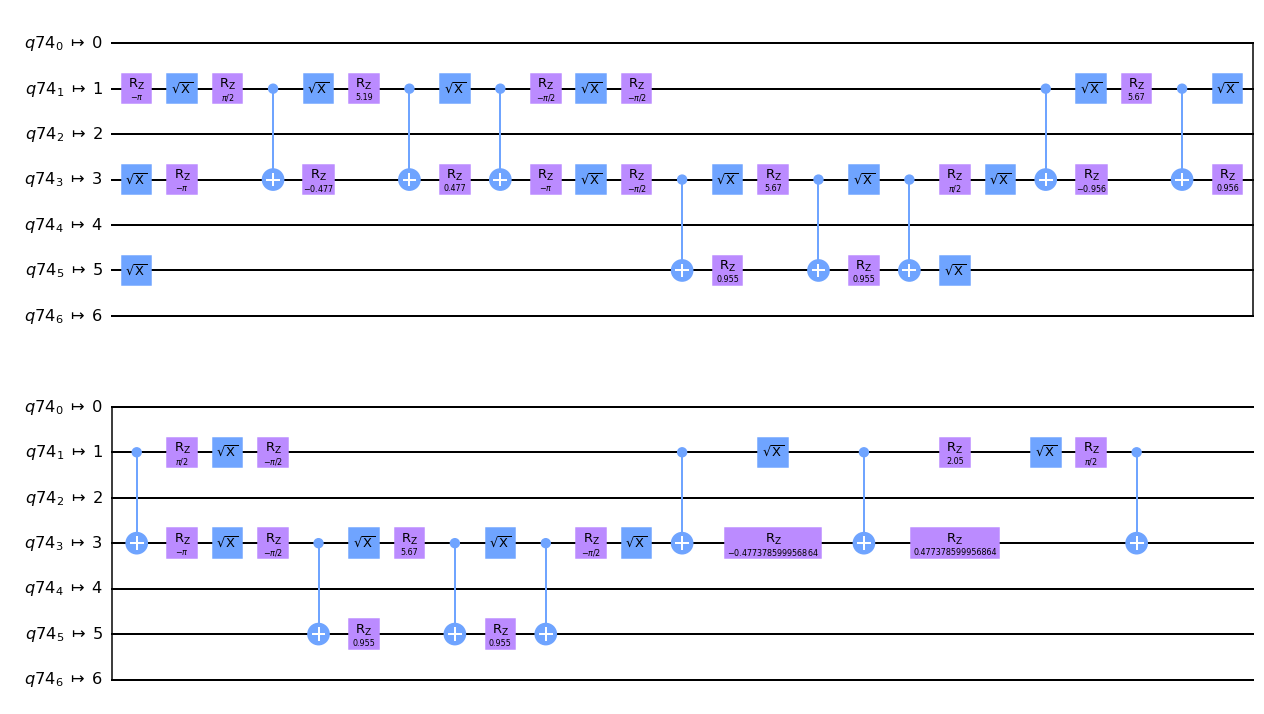

In [17]:
Trot_test = transpile(Trot_qc, optimization_level=3,backend=sim_noisy_jakarta)

Trot_test.draw('mpl')

The circuits for a different input state is created below. I test the solution with the input states $|110>$ and $(|010>+|110>)/\sqrt{2}$.

In [17]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr, name = "target_input")
qc.x([3,5])
qc.barrier(qr)
target_input = qc.to_instruction()

qr = QuantumRegister(7)
qc = QuantumCircuit(qr, name = "ext_input")
qc.x(3)
qc.h(5)
qc.barrier(qr)
ext_input = qc.to_instruction()

In addition to the circuit compression, I also apply a post-selection based on the symmetry verification technique [3]. An ancillary qubit is used as the flag to find all the shots which violate the specific symmetry of the Hamiltonian. 
<br/>
It is easy to check that the target Hamiltonian commutes with the operators $XXX$, $YYY$, and $ZZZ$. In my solution, I build a verification circuit using qubit 4 (benefit from the long T2 lifetime of qubit 4) to rule out any shot that violates the $ZZZ$ symmetry. The verification circuit is represented as:
$$
G = 0.5*(III-ZZZ)I + 0.5*(III+ZZZ)X
$$
Where in $PPPP$, $P$ is the Pauli operators in the code space of qubit 1, 3, 5, 4 from left to right.
<br/>
It is easy to verify that:
$$
G = G^{+}
$$
$$
GG^{+} = IIII
$$
$$
[G, H_{heisen}] = 0
$$

$$
GH_{heisen}G^{+} = H_{heisen}
$$

Where $H_{heisen}$ is the target Hamiltonian of $XXX$ Heisenberg model. The equations above show that if a noiseless simulation is performed, the simulated result of the circuit which represents $GH_{heisen}G^{+}$ is identical to the circuit for $H_{heisen}$. 
<br/>
For any operator $O = P_{1}P_{2}P_{3}$ in qubit 1, 3, 5 code space and anticommute with $ZZZ$: 
$$
GOG^{+} = (O)(IIIX) = P_{1}P_{2}P_{3}X
$$

Then, by adding this circuit G in two sides of the the main five alternative layers circuit $H_{heisen}$, the qubit 4 will be flipped from "0" to be "1" with the shot of the simulation which suffers from the anticommute noise $O$.
<br/>
By measuring qubit 4 and selecting out all the shots with the state "1" on qubit 4, off diagonal blocks between qubit 1, 3, 5, and qubit 4 of the density matrices becomes 0, and all the noise that anticommute with $ZZZ$ is reduced(remove $O$ which anticommute with $ZZZ$ from all the Kraus operators of the noise quantum channel).

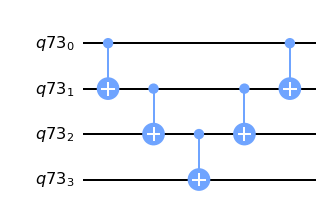

In [18]:
# construction of the verification circuit G
num_qubits = 4
qr = QuantumRegister(num_qubits)
zzz_qc = QuantumCircuit(qr, name='G')
zzz_qc.cnot(0, 1)
zzz_qc.cnot(1, 2)
zzz_qc.cnot(2, 3)
zzz_qc.cnot(1, 2)
zzz_qc.cnot(0, 1)
zzz = zzz_qc.to_instruction()
zzz_qc.draw('mpl')

In the following cell, I wrap all the circuits for the target state and time. Notice that I use "(XX+YY+ZZ)_inv" in the last alternative layer of the compressed trotterization circuit. In this way, two CNOTs gates in the adjacent area between the verification circuit $G$ and the compressed circuit are canceled on the right side. This cancellation also happens on the left side.   
<br/>
After transpile, the depth of the CNOTS for the circuit is 19. 

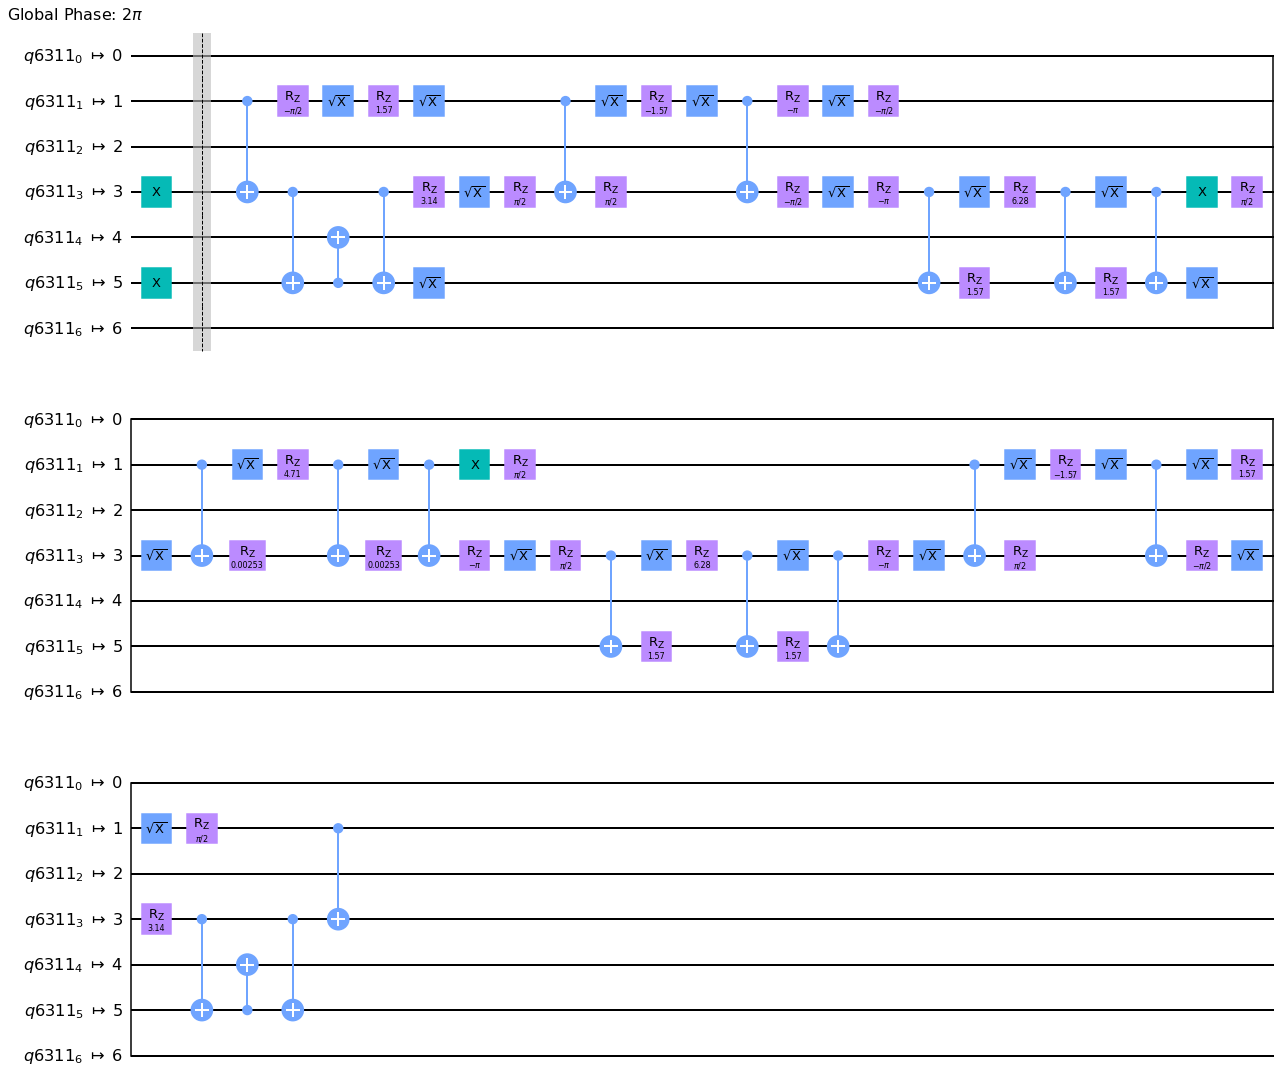

In [40]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc_target = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
qc_target.draw('mpl')

The tomograph circuits are created in the following cell. Two sets of the tomograph circuit are created.  *st_qcs_target_m* is the set of the circuits which are sent to the device, and the measurement is also performed on qubit 4 for the purpose of symmetry verification in this set of the circuits. The state tomograph is only performed in qubit 1, 3, 5 ,and *st_qcs* is created for the purpose of creating the input for *StateTomographyFitter*.      

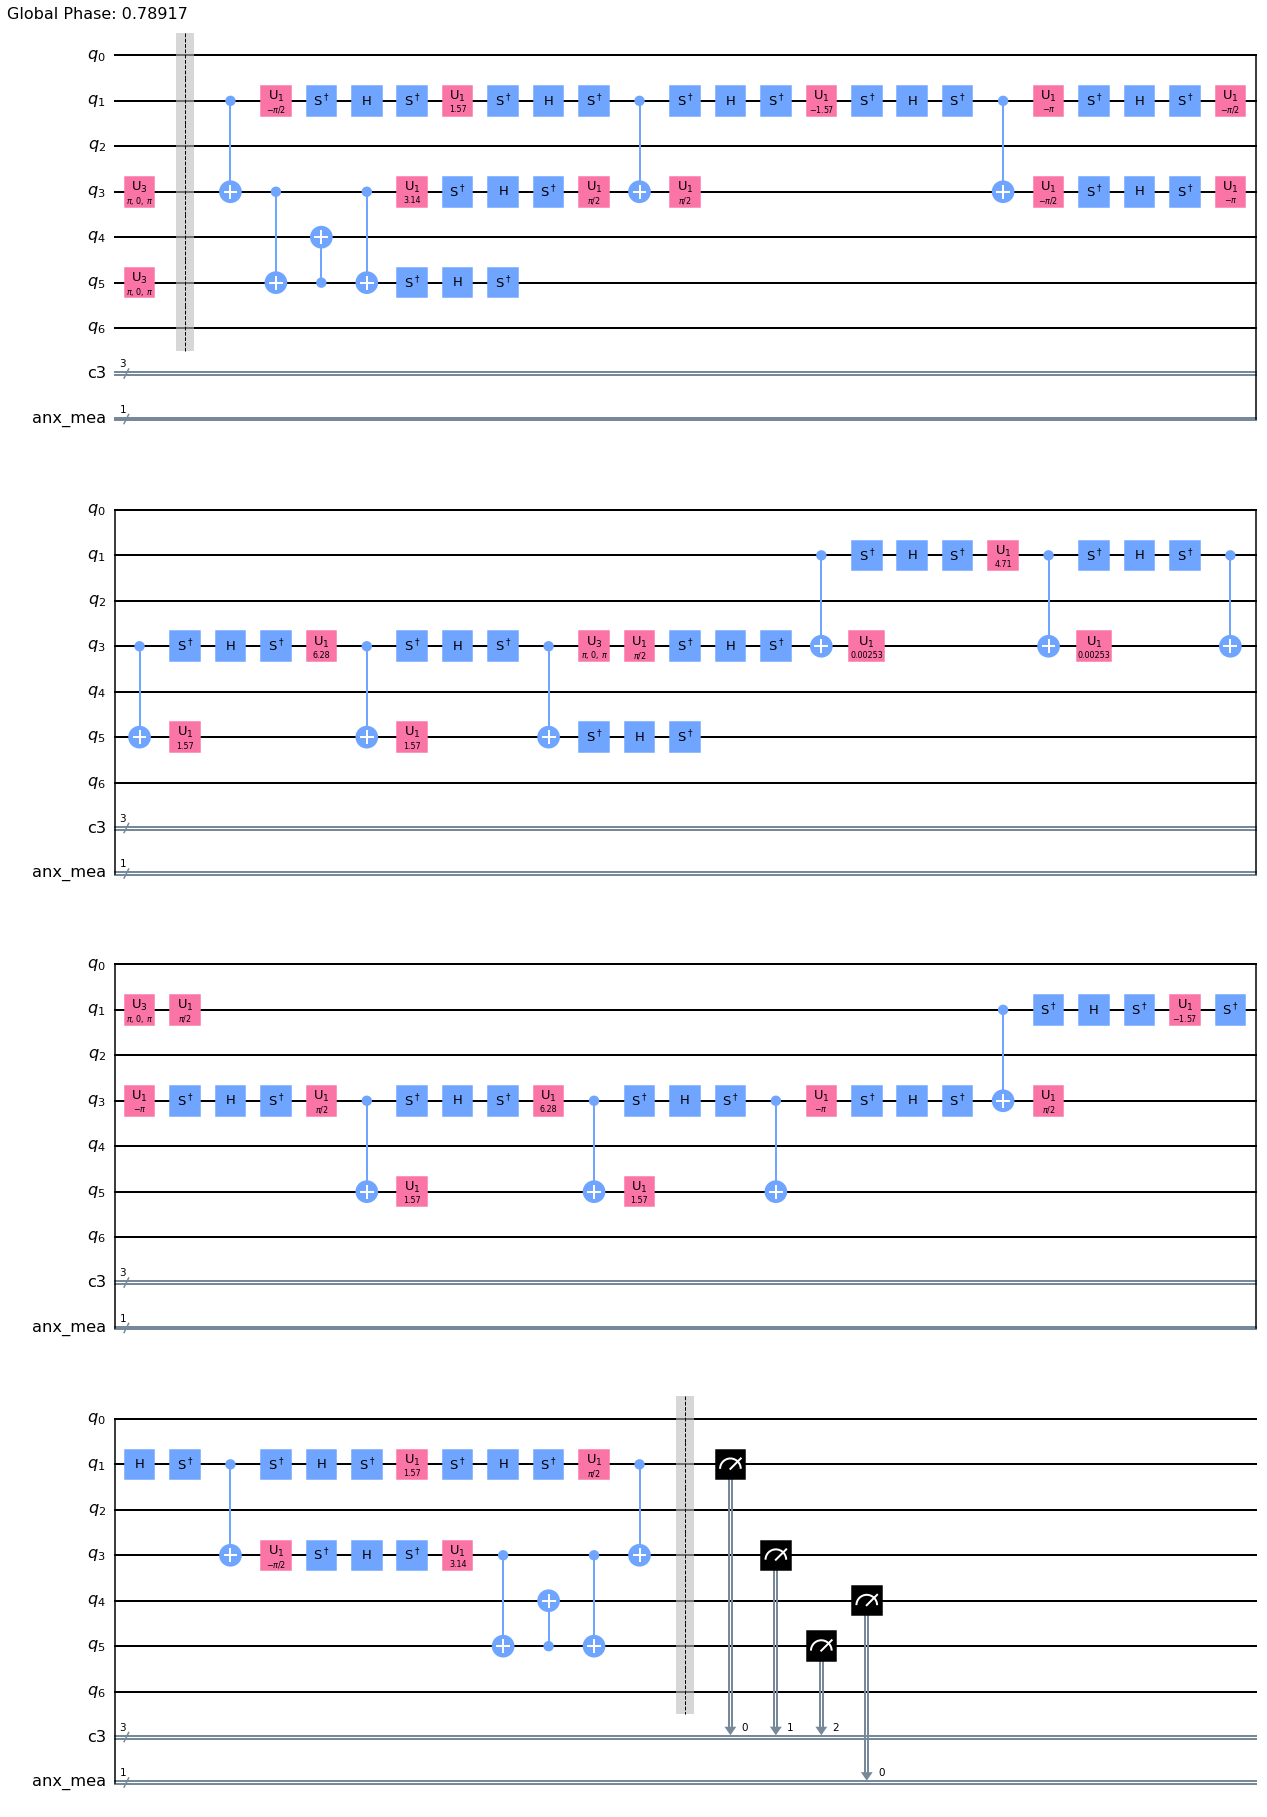

In [41]:
st_qcs_target_m = state_tomography_circuits(qc_target, [1,3,5])
st_qcs_target = []
for st_qc in st_qcs_target_m:
    st_qcs_target.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])

st_qcs_target_m[-1].decompose().draw('mpl')

Here, I sent jobs to the noise backend as an example. The jobs were run on the real device and the IDs are provided late.

In [42]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_target = []
for _ in range(reps):
    # execute
    job = execute(st_qcs_target_m, backend, shots=shots, optimization_level=0) # optimization is set to be 0 to avoid any unpredictable optimization
    print('Job ID', job.job_id())
    jobs_target.append(job)
    

Job ID 356a6936-207c-4ffd-aed7-f39a392d33f1
Job ID 009aa266-6204-4ec1-bd22-eee6dda090a8
Job ID a978300a-c47e-432e-8397-1e9782ce19bf
Job ID 7145a9d3-2ff8-46a2-83af-5d6efb1a2aef
Job ID 7a54bb0a-144e-4fbf-ad1b-a793bc473bcc
Job ID 3b43606e-3f2c-4f52-9b05-7b6d92f39e7e
Job ID 3b7fc2d1-2729-4631-b1f9-2fedf8c731ea
Job ID 4f58d9a7-e335-46e7-a394-2039a7a0a5fb


The *state_tomo* function is defined below which takes the job result, tomograph circuits without measurement in qubit 4, and the noiseless target output state as the input.

In [43]:
def state_tomo(result, st_qcs, target_state):
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    fid = state_fidelity(rho_fit, target_state)
    return fid

I also define a function *get_target_state* to calculate the noiseless target output state for any input initial state and evolution time $t$.  

In [44]:
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

def get_target_state(t, initial_state):
    
    state = (U_heis3(float(t)) @ initial_state).eval()
    state = state.to_matrix()
    state = qi.Statevector(state)
    return state

In this solution, a default version of the error mitigation is running to suppress the readout error of qubit 1, 3, 5, and 4. The details are provided in the qiskit tutorial:https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

In [45]:
shots =2**16 # 2^16 shots are ran with 8 times to have a good statistics for the unfolding
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())

Job ID 90fb1b94-72cb-48e9-bf84-ba5fd8591482
Job ID 6a81e690-efb6-4f12-a9f2-e76b457d3d0e
Job ID 651199fc-1512-4ade-8430-be9d4d4d1c35
Job ID 81ef27e0-30ac-49aa-b012-fddfe934d3ab
Job ID a38f0946-96fc-4abe-8de2-df40cb95a234
Job ID 56abfd86-cdfa-42cb-8aa3-30118a815117
Job ID f3a93c7d-2547-408a-8903-42777fcc2dbf
Job ID 8f06209a-3c17-4a24-8fdf-5f561c7859b9
Job ID 8f06209a-3c17-4a24-8fdf-5f561c7859b9


IOStream.flush timed out


In the following cell, the state labels of the error mitigator are modified to match the state labels of *st_qcs_target_m*.

In [46]:

results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

In the following cell, the post-process and state fidelity calculation is performed for the noise simulation. And some of the codes are used to create a new result object with the three-qubit state labels for the tomograph and the counts after the post-selection based on the symmetry verification.


In [47]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results) # error mitigation 
    new_results = copy.deepcopy(raw_results) # create a new result object
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        #built right state label
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0': # select only the count with qubit 4 "0"
                new_counts[reg_bits[1]]=old_counts[reg_key] # build right state label 
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state = 0.9056 ± 0.0018


In the following cell, I retrieve the jobs which were ran on real device on April 15th.

In [38]:
ids= [
     "62539c5a73968c8de707cf7a",
     "62539c5c5ab79bc3fef96f68",
     "62539c5ed720334e5267f5b7",
     "62539c61cfe45cce35e5c0a3",
     "62539c6273968c7c4c07cf7b",
     "62539c64f65d787612392084",
     "62539c654b51525f2a7c8865",
     "62539c67a5d4eef9ad77eaba",
     ]
jobs_target = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_target.append(job)

The creation date of the jobs is printed. 

In [29]:
for job in jobs_target:
    
    print(job.creation_date())

2022-04-10 23:11:22.850000-04:00
2022-04-10 23:11:24.900000-04:00
2022-04-10 23:11:26.615000-04:00
2022-04-10 23:11:29.725000-04:00
2022-04-10 23:11:30.869000-04:00
2022-04-10 23:11:32.413000-04:00
2022-04-10 23:11:33.655000-04:00
2022-04-10 23:11:34.999000-04:00


To obtain the best fidelity, I retrieve the calibration status of the noise simulation backend when the job was running on the real device.

In [39]:
sim_noisy_jakarta.properties=jobs_target[3].properties
#sim_noisy_jakarta.properties.__init__(last_update_date = "Apr 15, 2022 7:44 AM")

In [31]:
shots =2**16
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())


Job ID 5611d673-dbae-4377-89ef-11705ae248c1
Job ID 65c59048-1d78-46ae-9413-3f916f65f75f
Job ID e8953c14-4816-4601-87f5-329d5ef2d003
Job ID c5470e02-ac11-42a5-a202-0a7cd9c04f09
Job ID a0b8e13d-6bf9-4451-8339-41a69f4308e2
Job ID 30ad0b81-61fc-461a-bde7-b7ba46f0a2d6
Job ID 34ebbf40-038c-44a8-8345-5673436db874
Job ID 8c2612a7-f3f5-408b-be5b-944234eb1714
Job ID 8c2612a7-f3f5-408b-be5b-944234eb1714


In [32]:
results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

A state tomography fidelity $0.8757 \pm 0.0035$ is obtained.

In [33]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state = 0.8758 ± 0.0035


  The T1 and T2 lifetime of the qubit are supposed to be extended with the DD [4]. In the following cell, I add DD to my solution. I implement the DD with $XYXY$ series by hand on qubits 1, 3, and the ancillary qubit 4. 
<br/>
In the following cell, *gen_dd* function is used to create the DD series with the different intervals of the pulse and the number of the repetitions of $XYXY$ series. 

In [27]:
def gen_dd(n, rep): # n is the number of the gate time between the two pulses, and rep is the he number of the repetitions of XYXY series 

    num_qubits = 1
    dd_qr = QuantumRegister(num_qubits)
    dd_qc = QuantumCircuit(dd_qr, name='dd')
    dd_qc.barrier(0)
    for _ in range(2*rep):
        dd_qc.x(0)
        dd_qc.barrier(0)
        for _ in range(n):
            dd_qc.id(0)
            dd_qc.barrier(0)

        dd_qc.rz(-np.pi, 0)
        dd_qc.x(0)
        dd_qc.barrier(0)
        for _ in range(n):
            dd_qc.id(0)
            dd_qc.barrier(0) 
    return dd_qc

 *dd_circuit* function is used to add DD on the input circuit. Due to the time limit, I cannot give the best DD strategy. However, I have a study of the effect of the interval of the pulse on the individual qubit. According to this study, I will use 2 gate time intervals for qubit 1 and 4, and 1 gate time interval for qubit 5.

In [28]:
def dd_circuit(input_qc):

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    dd1 = gen_dd(1, 1)
    qc.append(dd1, [qr[5]])
    qc_dd5 = transpile(qc, optimization_level=0,backend=sim_noisy_jakarta)

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    dd2 = gen_dd(2, 1)
    qc.append(dd2, [qr[1]])
    qc_dd1 = transpile(qc, optimization_level=0,backend=sim_noisy_jakarta)

    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    dd3 = gen_dd(2, 1)
    qc.append(dd3, [qr[4]])
    qc_dd4 = transpile(qc, optimization_level=0,backend=sim_noisy_jakarta)
    
    qr = QuantumRegister(7)
    dd_qc = QuantumCircuit(qr)
    dd_qc = transpile(dd_qc, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
    dd_qc.data = input_qc.data[:11]
    for i in range(2):
        dd_qc.data += qc_dd1.data
    for i in range(3):
        dd_qc.data += qc_dd5.data
    for i in range(13):
        dd_qc.data += qc_dd4.data    
    dd_qc.data += input_qc.data[11:24] 
    for i in range(2):
        dd_qc.data += qc_dd1.data
    dd_qc.data += input_qc.data[24:36]
    for i in range(4):
        dd_qc.data += qc_dd5.data
    dd_qc.data += input_qc.data[36:48]
    for i in range(2):
        dd_qc.data += qc_dd1.data
    dd_qc.data += input_qc.data[48:57] 
    for i in range(3):
        dd_qc.data += qc_dd5.data
    dd_qc.data += input_qc.data[57:-4]
    for i in range(2):
        dd_qc.data += qc_dd1.data

    dd_qc.data += input_qc.data[-4:]
    
    return dd_qc

In [48]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc = dd_circuit(qc)

In the next two cells, I draw the pulse schedule for the circuit without DD and with DD to check if DD is implemented correctly.

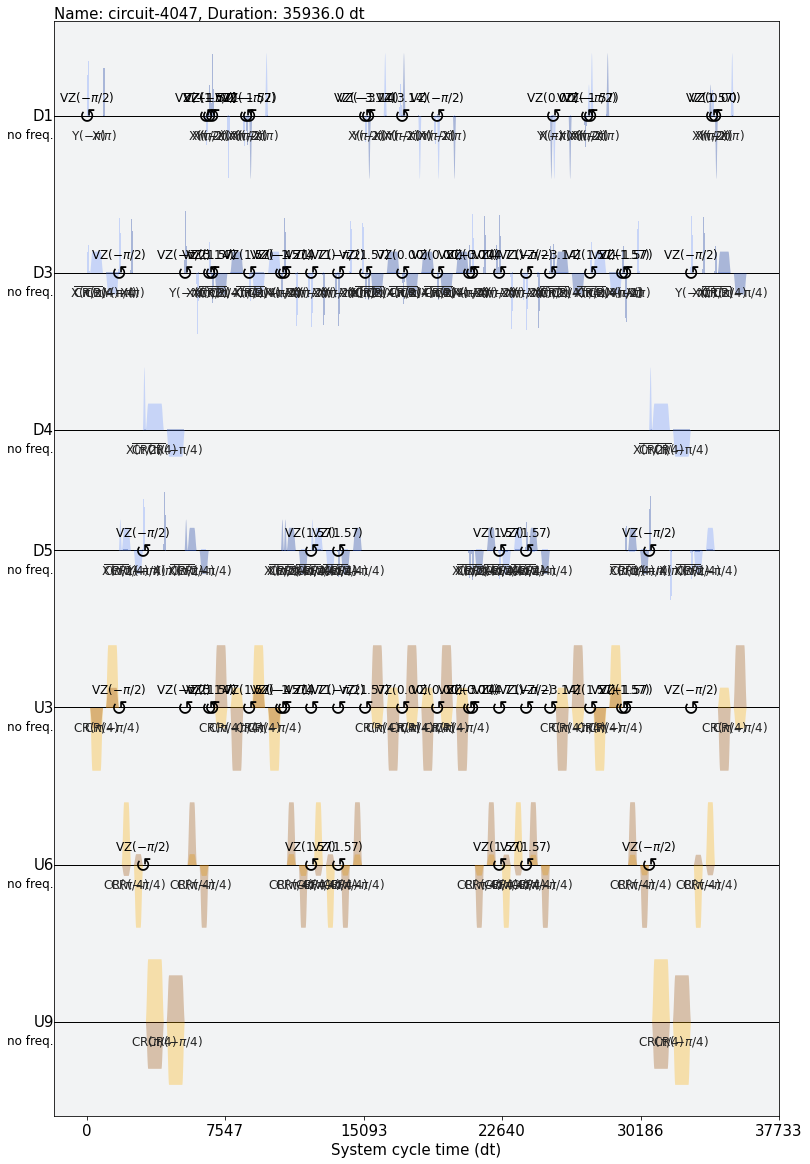

In [30]:
backend=jakarta
back_defaults = backend.defaults()
inst_map = back_defaults.instruction_schedule_map
sche = schedule(qc, backend=backend, inst_map=inst_map)
sche.draw()

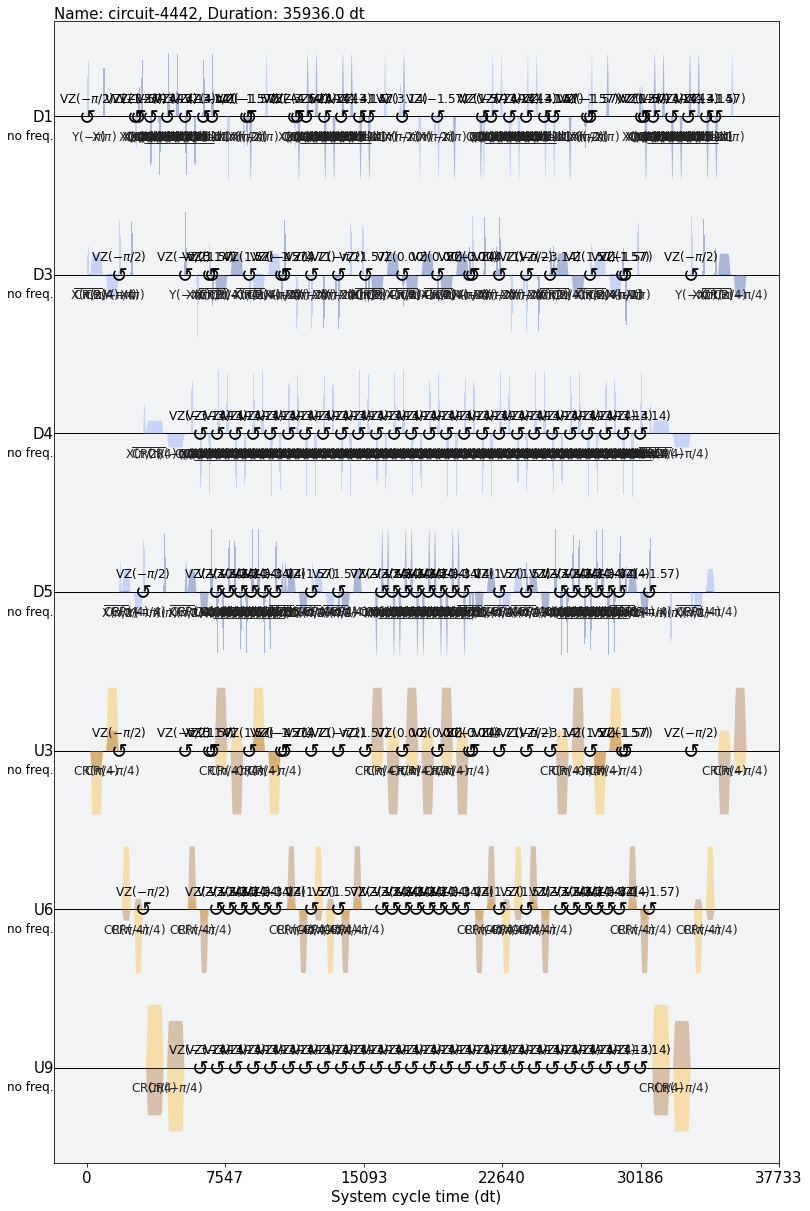

In [31]:
sche = schedule(dd_qc, backend=backend, inst_map=inst_map)
sche.draw()

It can be observed that after DD, the idle time of qubit is filled by the periodic pulse. And the total gate time keeps the same. 
<br/>
I wish the judges to help check if the total gate time doesn't increase when they run my solution. The calibration status changes day by day. It is possible that the gate time change and this DD will increase the total gate time. If that happens, I wish that the judges can adjust DD given the situation and reduce the DD series which causes the increase in the total gate time.

In the following several cells, I will run the solution for the target time and input state with the circuit with DD on a noise simulation backend. 

In [49]:
qr = QuantumRegister(7)
dd_qc_target = QuantumCircuit(qr)
dd_qc_target.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
dd_qc_target = transpile(dd_qc_target, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc_target.append(dd_qc, [0, 1, 2, 3, 4, 5, 6])

dd_st_qcs_target_m = state_tomography_circuits(dd_qc_target, [1,3,5])
dd_st_qcs_target = []
for st_qc in dd_st_qcs_target_m:
    dd_st_qcs_target.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])



In [50]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_dd_target = []
for _ in range(reps):
    # execute
    job = execute(dd_st_qcs_target_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_dd_target.append(job)

Job ID dc8ee69e-b843-4d06-b204-742f82c168f9
Job ID d3eb358a-1904-497b-bbb8-fadd4cb0800c
Job ID bf7f146f-f4c2-4780-b7f1-85adb27c694a
Job ID 753fda3e-0763-4961-b938-412d9a61d935
Job ID 5e67ad4a-a149-4fcc-82bb-5706fe97dfd9
Job ID 1720c9c4-4326-45eb-91b5-17b9da2104bd
Job ID b2232dba-23eb-4aa0-afe8-6a9c2fc07794
Job ID 3ea89042-0255-4aff-8b4f-dd096d59dc35


In [51]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_dd_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state with dd = 0.8869 ± 0.0020


The state fidelity for the noise simulation is $0.8869 \pm 0.002$. It is 1% lower than the noise simulation without DD. However, this is just the simulation, the performance with DD needs to be checked on the real device.

In the next several cells, I retrieve the jobs which were run on the real device with the DD for the target time and input state.

In [43]:

ids= [
     "62539c84cfe45c1189e5c0a4",
     "62539c87a5d4eef70f77eabc",
     "62539c8bf65d785d98392085",
     "62539c8e5ab79b02c7f96f6b",
     "62539c91182d0201aa4c4714",
     "62539c9573968c52c107cf7d",
     "62539c98fdf3772f7d570f2a",
     "62539c9bcfe45c51c7e5c0a5",
     ]
jobs_dd_target = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_dd_target.append(job)

Again, I retrieve the calibration status of the device when DD circuit was run for the error mitigation.

In [44]:
sim_noisy_jakarta.properties=jobs_dd_target[3].properties

In [45]:
shots =2**16
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())

Job ID 719eaa35-e015-467e-8782-f32db004a4f2
Job ID 90b08398-9d8b-4213-bccd-937209e645f7
Job ID a2655ca4-c2a1-430e-b39d-c0ab22912a03
Job ID ef31e268-9cb9-4099-a37d-5dd6a2640c03
Job ID 6978620e-c189-4d69-a4c0-a029d78ebd7b
Job ID 72a85c3d-e226-47dd-b1da-4cb3de740560
Job ID c26384e9-e43c-45ba-8fb1-11b8e699a244
Job ID 8f515a0d-eedf-4928-9e28-1c9853be0617
Job ID 8f515a0d-eedf-4928-9e28-1c9853be0617


IOStream.flush timed out


In [46]:
results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

In [47]:
target_state = get_target_state(target_time ,One^One^Zero)

fids = []
for job in jobs_dd_target:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_target, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and initial state with dd = 0.8837 ± 0.0046


A state tomography fidelity $0.8839 \pm 0.0047$ is obtained. About 1% improvement compared to no DD version of the result. 

In the last part of the solution, I will test my solution the with:

1. The evolution time $\pi/2$.
2. The input state $(|110>+|010>)/\sqrt{2}$. 

In the next several cells, I create a circuit for the evolution time $\pi/2$ and target input state.

In [35]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_half_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc = dd_circuit(qc)

Again, the pulse schedule is checked to verify if DD is implemented correctly.

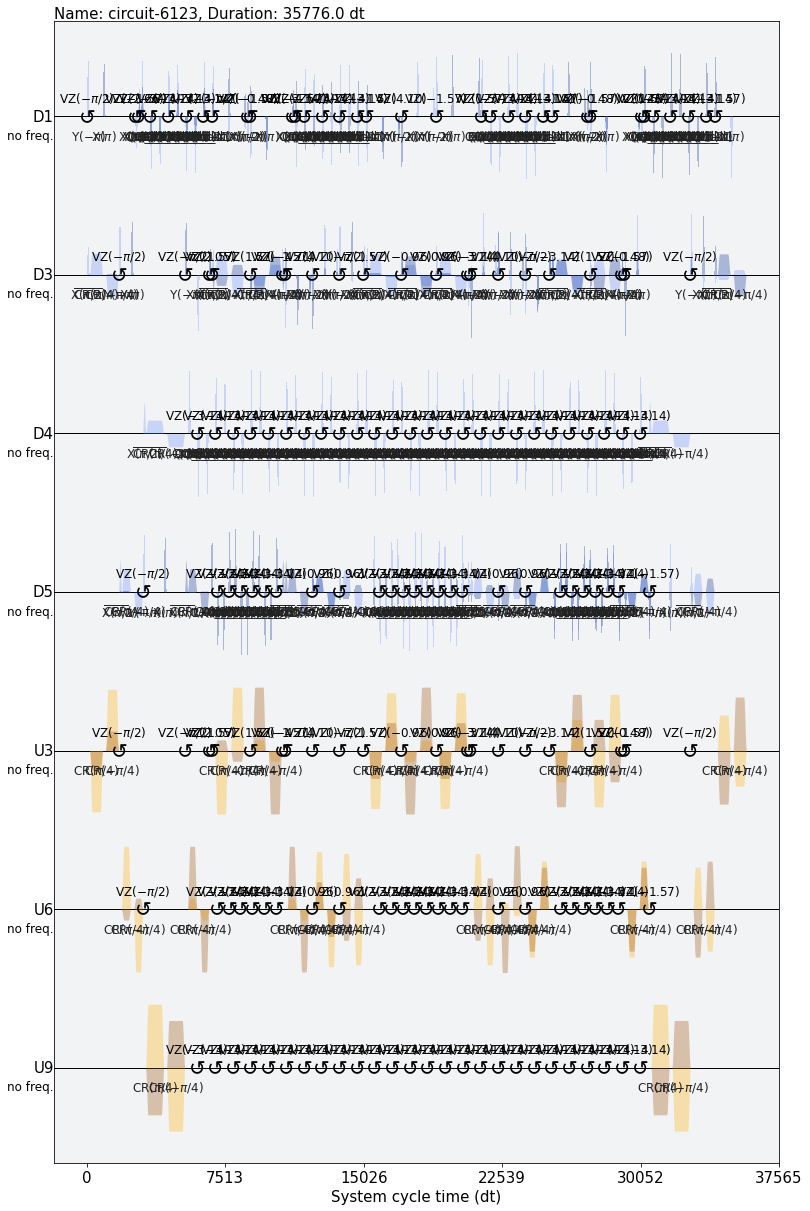

In [36]:
backend=jakarta
back_defaults = backend.defaults()
inst_map = back_defaults.instruction_schedule_map
sche = schedule(dd_qc, backend=jakarta, inst_map=inst_map)
sche.draw()

The tomograph circuits are created and run in the noise simulation backend.

In [50]:
qr = QuantumRegister(7)
dd_qc_half = QuantumCircuit(qr)
dd_qc_half.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
dd_qc_half = transpile(dd_qc_half, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc_half.append(dd_qc, [0, 1, 2, 3, 4, 5, 6])

dd_st_qcs_half_m = state_tomography_circuits(dd_qc_half, [1,3,5])
dd_st_qcs_half = []
for st_qc in dd_st_qcs_half_m:
    dd_st_qcs_half.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])

In [51]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_dd_half = []
for _ in range(reps):
    # execute
    job = execute(dd_st_qcs_half_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_dd_half.append(job)

Job ID dfbea93b-7a42-4ec4-bf94-00cfa7c1fc26
Job ID 9e2812a5-ce32-4cc1-813f-78f4939f09d0
Job ID de198256-6de9-4c4e-9f15-ce02ebe13a4a
Job ID 9307d989-cf8d-4d93-a21e-01096c240972
Job ID a2c216d0-343f-41ca-a5f6-5826a2c70042
Job ID 9ab3adc6-cb6c-430b-a5f1-0393cc0c419c
Job ID 6e6baa39-97b7-4072-8112-fd1c2114bba4
Job ID 8b625c69-7b20-4c29-8fe6-799058c909f6


The The state tomography fidelity for the noise simulation is $0.8455 \pm 0.0019$ with the evolution time $\pi/2$.

In [52]:
target_state = get_target_state(target_time/2 ,One^One^Zero)

fids = []
for job in jobs_dd_half:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_half, target_state)
    fids.append(fid)
    
print('state tomography fidelity for 0.5 pi time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for 0.5 pi time and initial state with dd = 0.8455 ± 0.0019


 Again, I retrieve the jobs which were run on the real device and the calibration status of the device when those jobs were run for error mitigation. 

In [54]:

ids= [
     "62539faefdf377eaba570f4b",
     "62539fb273968c4faa07cf96",
     "62539fb5fdf3770abb570f4c",
     "62539fbaa5d4ee3b0a77ead5",
     "62539fc0cfe45cacc7e5c0c3",
     "62539fc4f65d787efa392095",
     "62539fc7182d02d2ff4c4729",
     "62539fcffdf377e751570f4d",
     ]
jobs_dd_half = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_dd_half.append(job)

In [55]:
sim_noisy_jakarta.properties=jobs_dd_half[3].properties
shots =2**16
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())

Job ID e95804a5-2e33-459b-8e55-bf334084c911
Job ID 7bd26c65-9f41-4a4a-9ed2-a26a9b002614
Job ID 04fb81fb-a905-4ba9-95ae-4e8372244ceb
Job ID 080b4c1e-da0c-4863-8b27-503b83c7085d
Job ID 51ea4fe7-2aee-4337-b1e4-b72c0b1c3c64
Job ID 5777f2a4-53eb-46b0-b419-cc5a1ef9057e
Job ID 02789eff-93aa-4963-9079-64597e6ad8f3
Job ID ee24822f-ddab-46f7-a855-58abe1ba5843
Job ID ee24822f-ddab-46f7-a855-58abe1ba5843


In [56]:
results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

In [57]:
target_state = get_target_state(target_time/2 ,One^One^Zero)

fids = []
for job in jobs_dd_half:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]

        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_half, target_state)
    fids.append(fid)
    
print('state tomography fidelity for 0.5 pi time and initial state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for 0.5 pi time and initial state with dd = 0.8209 ± 0.0099


The state tomography fidelity is $0.8208 \pm 0.01$ which is significantly lower than the target time and input state.

In the following cells, I test the performance of the solution with input state $(|110>+|010>)/\sqrt{2}$, which is the most difficult case since the qubit 4 stays in the superposition of "0" and "1" for a long time. I expect that the result suffers from a large dephase compared to the other two cases.
<br/>

Again, I create the circuit and check the pulse schedule.

In [58]:
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc.append(Trot_pi, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
qc.append(zzz, [qr[1], qr[3], qr[5], qr[4]])
qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc = dd_circuit(qc)

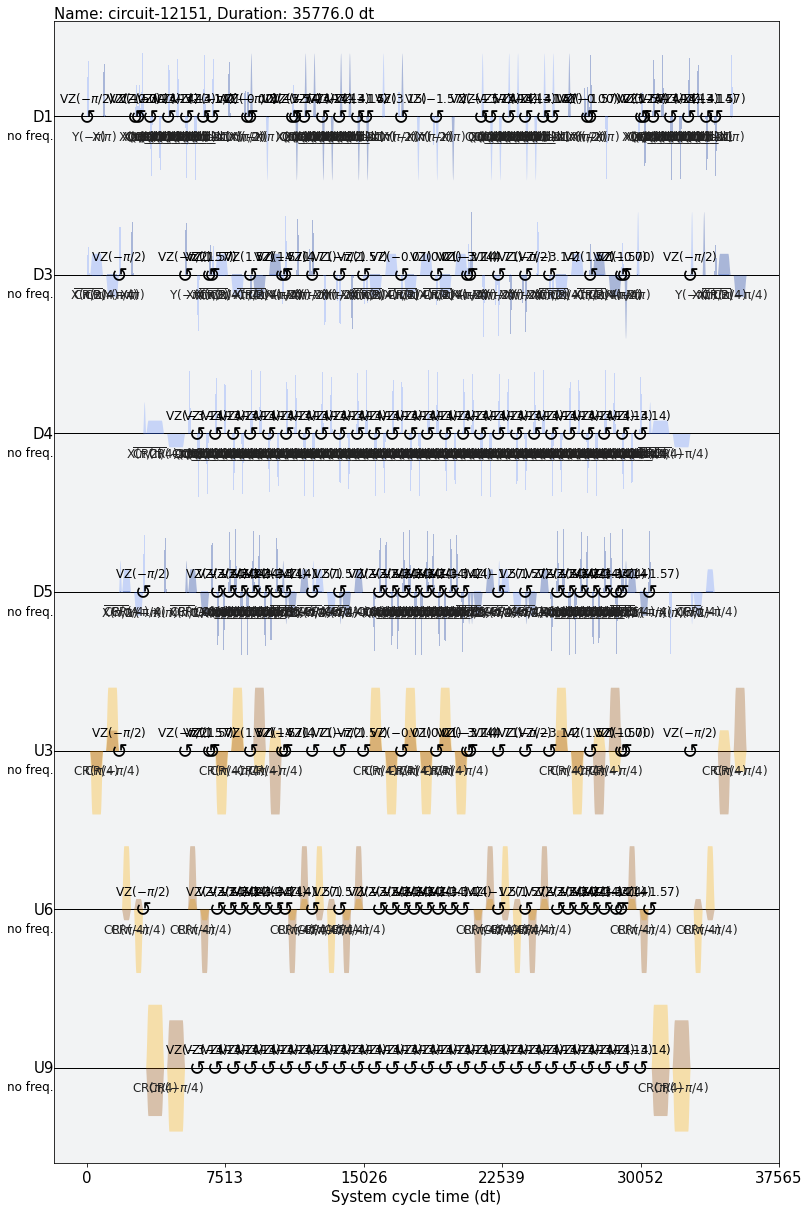

In [59]:
sche = schedule(dd_qc, backend=backend, inst_map=inst_map)
sche.draw()

Run the circuit on the noise simulation.

In [60]:
qr = QuantumRegister(7)
dd_qc_ext = QuantumCircuit(qr)
dd_qc_ext.append(ext_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
dd_qc_ext = transpile(dd_qc_ext, optimization_level=0,backend=sim_noisy_jakarta, approximation_degree=1.)
dd_qc_ext.append(dd_qc, [0, 1, 2, 3, 4, 5, 6])

dd_st_qcs_ext_m = state_tomography_circuits(dd_qc_ext, [1,3,5])
dd_st_qcs_ext = []
for st_qc in dd_st_qcs_ext_m:
    dd_st_qcs_ext.append(st_qc.copy())
    cr=ClassicalRegister(1, "anx_mea")
    st_qc.add_register(cr)
    st_qc.measure([4], [cr[0]])

In [61]:
shots = 8192
reps = 8
#backend=sim
backend = sim_noisy_jakarta
#backend = jakarta

jobs_dd_ext = []
for _ in range(reps):
    # execute
    job = execute(dd_st_qcs_ext_m, backend, shots=shots, optimization_level=0)
    print('Job ID', job.job_id())
    jobs_dd_ext.append(job)

Job ID 30b88e72-3fe3-42db-8631-4e95fe8d93ef
Job ID e4e2a2e6-9015-42f9-bd38-3176843d8aae
Job ID 82172c40-3281-481e-b0a4-4808a2f8b090
Job ID 48bb9b71-fe82-4c29-9581-f859e5796b89
Job ID ed71490e-0d72-4a0f-9a67-aefc488b0ef8
Job ID 7865418f-ca96-4300-a369-1dcea752289a
Job ID 0f7d52e3-d5c7-4aea-8a46-36c206c00681
Job ID f3b66940-bb09-4230-b5a8-86237ae18fac


The state tomography fidelity for target time and $|110>+|010>/\sqrt{2}$ with the noise simulation is $0.8927 \pm 0.0018$

In [62]:
target_state = get_target_state(target_time ,((Zero+One)/np.sqrt(2))^One^Zero)

fids = []
for job in jobs_dd_ext:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_ext, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and |110> + |010> superposition state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and |110> + |010> superposition state with dd = 0.8927 ± 0.0011


Again, I retrieve the results from the real device.

In [63]:

ids= [
      "6253a1ef73968c7c8007cfac",
      "6253a1f5182d0251634c4735",
      "6253a1fbcaa265193af1b7cb",
      "6253a1fef65d7851173920a6",
      "6253a2014b5152f8027c8889",
      "6253a206fdf3772ca7570f5e",
      "6253a20bcaa2658ceaf1b7cc",
      "6253a211fdf3775364570f5f",
      ]
jobs_dd_ext = []
for idx in ids:
    job = jakarta.retrieve_job(idx)
    jobs_dd_ext.append(job)

In [64]:
sim_noisy_jakarta.properties=jobs_dd_ext[3].properties
shots =2**16
backend = sim_noisy_jakarta
#backend = jakarta
qr = QuantumRegister(7)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[4, 1, 3, 5], qr=qr, circlabel='mcal')
jobs_readout = []
for _ in range(8):
    # execute
    job = execute(meas_calibs, backend, shots=shots, optimization_level=None)
    print('Job ID', job.job_id())
    jobs_readout.append(job)

print('Job ID', job.job_id())

Job ID cec281f4-d066-4c0b-912b-57e8898d629a
Job ID 189091f4-a067-4709-a6f1-74eb6179ffcb
Job ID 87640bd7-198d-4ce6-a50f-ef93eabcb875
Job ID 6dd0ee2d-d876-406d-b0db-e253b65993ec
Job ID 64d08eb5-1305-4b8d-bca5-0d0e07034a54
Job ID e0d87b6e-d5e5-4812-b973-f8d4f206ace1
Job ID 6bc3dd19-a37e-4758-a851-60813def96c5
Job ID 21277585-551e-48ca-a3a2-7e0e07948014
Job ID 21277585-551e-48ca-a3a2-7e0e07948014


IOStream.flush timed out


In [65]:
results = [job.result() for job in jobs_readout]
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
err_mitig = copy.deepcopy(meas_fitter)

for i in range(len(meas_fitter.state_labels)):
    state_label_raw = meas_fitter.state_labels[i]
    state_label = state_label_raw[0] + ' ' + state_label_raw[1:4]
    err_mitig.state_labels[i] = state_label

In [66]:
target_state = get_target_state(target_time ,((Zero+One)/np.sqrt(2))^One^Zero)

fids = []
for job in jobs_dd_ext:
    raw_results = job.result()
    raw_results = err_mitig.filter.apply(raw_results)
    new_results = copy.deepcopy(raw_results)
    for resultidx, _ in enumerate(raw_results.results):
        old_counts = raw_results.get_counts(resultidx)
        new_counts = {}
        new_results.results[resultidx].header.creg_sizes = [new_results.results[resultidx].header.creg_sizes[0]]
        new_results.results[resultidx].header.clbit_labels = new_results.results[resultidx].header.clbit_labels[0:-1]
        new_results.results[resultidx].header.memory_slots = 3
        
        for reg_key in old_counts:
            reg_bits = reg_key.split(' ')
            if reg_bits[0]=='0':
                new_counts[reg_bits[1]]=old_counts[reg_key]
       
        new_results.results[resultidx].data.counts = new_counts

    fid = state_tomo(new_results, dd_st_qcs_ext, target_state)
    fids.append(fid)
    
print('state tomography fidelity for target time and |110> + |010> superposition state with dd = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity for target time and |110> + |010> superposition state with dd = 0.8648 ± 0.0094


  The state tomography fidelity for a target time and $|010>+|110>/\sqrt{2}$ input state on the real device is $0.8648 \pm 0.0094$, which is surprised better than I expected. In my previous test without DD, $0.7$ fidelity is observed. I guess DD is helpful to keep the qubit 4 from the influence of noise in the environment. 

# Reference:

1. S. Gulania, B. Peng, Y. Alexeev, and N. Govind, "Quantum time dynamics of 1D-Heisenberg models employ- ing the Yang-Baxter equation for circuit compression", arXiv:2112.01690(2021).

2. L. Bassman, R. Van Beeumen, E. Younis, E. Smith, C. Iancu, W. de Jong, Constant-depth circuits for dynamic simulations of materials on quantum computers, arXiv:2103.07429(2021).

3. X. Bonet-Monroig, R. Sagastizabal, M. Singh, T. E. O’Brien, "Low-cost error mitigation by symmetry verification", PHYSICAL REVIEW A 98, 062339(2018). 

4. B. Pokharel, N. Anand, B. Fortman, D. Lidar, "Demonstration of fidelity improvement using dynamical decoupling with superconducting qubits", arXiv:1807.08768(2018).

# Appendix. A 
## Eigenstate and values of the target Hamilitonian

Eigenvalue:
$$
\lambda = 2
$$
Eigentates:
$$
|111>
$$
$$
|000>
$$
$$
(|001>+|010>+|100>)/\sqrt{3}
$$
$$
(|011>+|110>+|101>)/\sqrt{3}
$$
Eigenvalue:
$$
\lambda = 0
$$
Eigentates:
$$
(|001>-|100>)/\sqrt{2}
$$
$$
(|011>-|110>)/\sqrt{2}
$$

Eigenvalue:
$$
\lambda = -4
$$
Eigentates:
$$
(|001>+|100>-2|010>)/\sqrt{6}
$$
$$
(|011>+|110>-2|101>)/\sqrt{6}
$$

# Appendix. B 
## Circuit compression test

In the following cell, I test circuit compression with the different evolution times and noiseless simulation. The result shows that the compression succeeds in evolution time $\pi/10$, $2\pi/10$, $3\pi/10$ .....

In [55]:
times = np.linspace(target_time/10., target_time, 10)

for time in times:
    paras = compression(5, time)
    num_qubits = 7
    qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(qr, name='Trot')
    Trot_qc.append(XYZ_1, [qr[1], qr[3]])
    Trot_qc.append(XYZ_2, [qr[3], qr[5]])
    Trot_qc.append(XYZ_3, [qr[1], qr[3]])
    Trot_qc.append(XYZ_2, [qr[3], qr[5]])
    Trot_qc.append(XYZ_1_inv, [qr[1], qr[3]])
    Trot_qc=Trot_qc.bind_parameters({beta1:paras[0],beta2:paras[1], beta3:paras[2]})
    Trot = Trot_qc.to_instruction()
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    qc.append(target_input, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
    qc.append(Trot, [qr[0], qr[1], qr[2], qr[3], qr[4], qr[5], qr[6]])
    qc = transpile(qc, optimization_level=3,backend=sim_noisy_jakarta, approximation_degree=1.)
    st_qcs = state_tomography_circuits(qc, [1,3,5])
    shots = 8192
    reps = 8
    backend=sim
    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots, optimization_level=0) # optimization is set to be 0 to avoid any unpredictable optimization
        #print('Job ID', job.job_id())
        jobs.append(job)
        
    target_state = get_target_state(time ,One^One^Zero)
    fids = []
    for job in jobs:
        results = job.result()
        fid = state_tomo(results, st_qcs, target_state)
        fids.append(fid)
    
    print('state tomography fidelity for target time {:.4f} and initial state = {:.4f} \u00B1 {:.4f}'.format(time, np.mean(fids), np.std(fids)))

state tomography fidelity for target time 0.3142 and initial state = 0.9959 ± 0.0009
state tomography fidelity for target time 0.6283 and initial state = 0.9966 ± 0.0009
state tomography fidelity for target time 0.9425 and initial state = 0.9959 ± 0.0012
state tomography fidelity for target time 1.2566 and initial state = 0.9959 ± 0.0016
state tomography fidelity for target time 1.5708 and initial state = 0.9960 ± 0.0008
state tomography fidelity for target time 1.8850 and initial state = 0.9958 ± 0.0008
state tomography fidelity for target time 2.1991 and initial state = 0.9961 ± 0.0012
state tomography fidelity for target time 2.5133 and initial state = 0.9955 ± 0.0015
state tomography fidelity for target time 2.8274 and initial state = 0.9964 ± 0.0015
state tomography fidelity for target time 3.1416 and initial state = 0.9958 ± 0.0006


# Appendix. C 
## A short deduction of the analytical form of Conjecture 5

Here, I provide a short note about how I obtained the analytical form of **Conjecture 5**. It is well known that the isotropic Heisenberg model can be represented in the permutation group space. In the $XXX$ model case, between any two sites $i, j$ with the interaction, there is:

$$
2p_{i,j} - 1 = X_{i}X_{j} + Y_{i}Y_{j} + Z_{i}Z_{j}
$$

Where $p_{i,j}$ is the permutation operator which swaps the quantum state between the sites $i, j$.

<br/>

With this relation, the **Conjecture 5** can be written as:

$$
e^{-i\alpha_{1}(2p_{12}-1)}e^{-i\alpha_{2}(2p_{23}-1)}e^{-i\alpha_{3}(2p_{12}-1)}e^{-i\alpha_{2}(2p_{23}-1)}e^{-i\alpha_{1}(2p_{12}-1)} = e^{-i\beta_{1}(2p_{23}-1)}e^{-i\beta_{2}(2p_{12}-1)}e^{-i\beta_{3}(2p_{23}-1)}e^{-i\beta_{2}(2p_{12}-1)}e^{-i\beta_{1}(2p_{23}-1)} 
$$
Since $1$ is unit and commute with any group element, the form of the above equation can be future reduced:
$$
e^{-i2\alpha_{1}p_{12}}e^{-i2\alpha_{2}p_{23}}e^{-i2\alpha_{3}2p_{12}}e^{-i2\alpha_{2}p_{23}}e^{-i2\alpha_{1}p_{12}} = e^{-i2\beta_{1}p_{23}}e^{-i2\beta_{2}p_{12}}e^{-i2\beta_{3}p_{23}}e^{-i2\beta_{2}p_{12}}e^{-i2\beta_{1}p_{23}}
$$
By expanding the above equation from the exponential form, a total of 6 equations are obtained which are the equations of the 6 group elements of $S3$ symmetry group. And with the mirror symmetry constraint, the total number of the independent equations is reduced to 5 as I was shown in the previous cell.

$$
  f_{1}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{1}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{2}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{2}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{3}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{4}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{4}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{3}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$
$$
  f_{5}(2\alpha_{1}, 2\alpha_{2}, 2\alpha_{3}) = f_{5}(2\beta_{1}, 2\beta_{2}, 2\beta_{3})
$$

Where $f_{i}$ are:

$$
f_{1}(x, y, z) = cos(2x)cos(2y)cos(z) - sin(2x)cos(y)^{2}sin(z)
$$

$$
f_{2}(x, y, z) = -sin(x)^{2}sin(2y)cos(z) - cos(x)^{2}sin(y)^{2}sin(z) - 0.5sin(2x)sin(2y)sin(z)
$$

$$
f_{3}(x, y ,z) = cos(2x)cos(y)^{2}sin(z) + sin(2x)cos(2y)cos(z)
$$

$$
f_{4} = cos(x)^{2}sin(2y)cos(z) + sin(x)^{2}sin(y)^{2}sin(z) - 0.5sin(2x)sin(2y)sin(z)
$$

$$
f_{5} = -0.5sin(2x)sin(2y)cos(z) -0.5cos(2x)sin(2y)sin(z) + 0.5sin(2x)sin(y)^{2}sin(z)
$$

# Appendix. D 
## A study of the effect of DD

As I mentioned before, the fidelity of the input state $(|110>+|010>)/\sqrt{2}$ is surprised better than I expect. I was expecting that the qubit 4 stays in the superposition of "0" and "1" for a long time and the result suffers from a large dephase. However, it looks like this is not the case.
<br/>
I guess DD has an effect to protect qubit 4 from the noise. So, I submitted two sets of the jobs for the Hamiltonian simulation with the initial state $(|110>+|010>)/\sqrt{2}$ and target time for the $XXX$ Heisenberg model. The two sets of the jobs are successive. In the first set of jobs, DD is implemented in the circuit. And in the second set of the jobs, I do not implement DD. In the following cell, I provide the job id.  
<br/>
I submitted them before the extended week. However, those jobs are unlike to be finished in the extended week. So, I still cannot give a conclusion if there is an improvement of the DD. I will keep DD in my main solution anyway.  

# w/o DD

Job ID 625adf487368943fc2c8bb9b
Job ID 625adf4c8e4b2378e3d308fc
Job ID 625adf4f8e4b23c4f1d308fd
Job ID 625adf51f1fb8dd7eb3ad7f5
Job ID 625adf54a7e96632acdee72c
Job ID 625adf55e3b67f3c783abc4f
Job ID 625adf58e1f24510d8eb6bab
Job ID 625adf5a7368947215c8bb9c

# w/ DD

Job ID 625adf6835e1ecb1eb25361b
Job ID 625adf698e4b23ec41d308ff
Job ID 625adf6aa7e9664fdfdee72d
Job ID 625adf6be3b67ffebc3abc50
Job ID 625adf6c35e1ec897725361c
Job ID 625adf6ee1f245778eeb6bac
Job ID 625adf6f0d8f19682cac1972
Job ID 625adf713bbc9f89b5735af7